In [1]:

import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np




df = pd.read_excel('Новый диплом датасет.xlsx', sheet_name='Данные')
clients = pd.read_excel ('Новый диплом датасет.xlsx', sheet_name='Clients')
region_dict = pd.read_excel ('Новый диплом датасет.xlsx', sheet_name='Region_dict')


df.dropna(inplace=True)
clients.dropna(inplace=True)
region_dict.dropna(inplace=True)


clients['dtime_ad'] = clients['dtime_ad'].apply(pd.Timestamp)


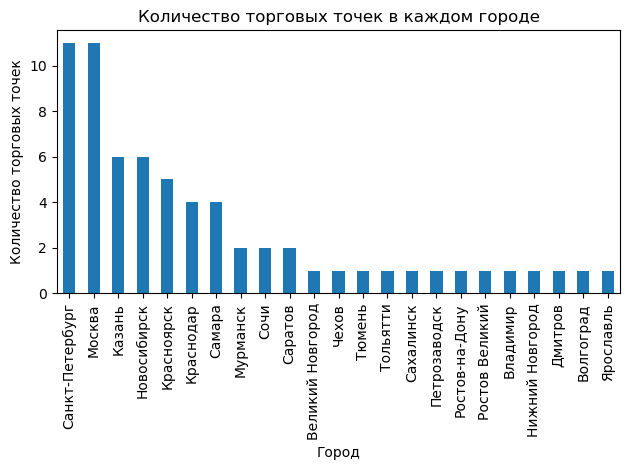

In [2]:

trading_points_by_city = region_dict.groupby('city')['id_trading_point'].nunique()


trading_points_by_city = trading_points_by_city.reset_index(name='num_trading_points')


trading_points_by_city = trading_points_by_city.sort_values('num_trading_points', ascending=False)


trading_points_by_city.plot(kind='bar', x='city', y='num_trading_points', legend=False)
plt.xlabel('Город')
plt.ylabel('Количество торговых точек')
plt.title('Количество торговых точек в каждом городе')
plt.tight_layout()
plt.show()

In [3]:
df = df.merge(clients, on = 'id_client', how = 'outer')
df = df.merge(region_dict, on = 'id_trading_point')

df['amt_payment'] = df['amt_payment'].fillna(0)

df_cl = df.groupby(['id_client','id_trading_point','city']).agg({'id_order':'count', 'amt_payment':'sum'}).reset_index()

cleaned_data = df_cl.merge(clients[['id_client','dtime_ad','nflag_test']], on = 'id_client')

cleaned_data['nflag_paid'] = np.where(cleaned_data['amt_payment'] > 0, 1, 0)


In [4]:
cleaned_data.head()

,id_client,id_trading_point,city,id_order,amt_payment,dtime_ad,nflag_test,nflag_paid
0,178561.0,453.0,Санкт-Петербург,1,3052.0,2022-06-03 02:47:49.183,0,1
1,178562.0,2652.0,Москва,1,2439.0,2022-06-03 02:51:21.878,0,1
2,178563.0,112.0,Санкт-Петербург,1,768.0,2022-06-03 02:52:10.616,1,1
3,178564.0,26.0,Ростов-на-Дону,0,0.0,2022-06-03 02:53:10.089,1,0
4,178565.0,739.0,Новосибирск,1,958.0,2022-06-03 02:55:13.525,1,1


In [5]:
def test_calc(r1, r2):
    
    t_statistic, p_value = stats.ttest_ind(r1, r2)

    
    if p_value < 0.05:
        print(f"Есть статистически значимая разница между средними (p_value = {p_value}).")
    else:
        print(f"Нет статистически значимой разницы между средними (p_value = {p_value:}).")

    return   t_statistic, p_value  



In [6]:
def mann_whitney_func(r1, r2, alpha=0.05):
   
    statistic, p_value = stats.mannwhitneyu(r1, r2)

    
    if p_value < alpha:
        print(f"Существует статистически значимая разница между распределениями (p_value = {p_value}).")
    else:
        print(f"Нет статистически значимой разницы между распределениями (p_value = {p_value:}).")

    return   statistic, p_value      



In [7]:
no_payments_points = []

for i in cleaned_data['id_trading_point'].unique():
    
    c_a = cleaned_data[(cleaned_data['id_trading_point']==i) & (cleaned_data['nflag_test']==0)].count()['id_client']
    c_b = cleaned_data[(cleaned_data['id_trading_point']==i) & (cleaned_data['nflag_test']==1)].count()['id_client']
    if (c_a == 0) | (c_b == 0):
        no_payments_points.append(i)

print(no_payments_points)

[739.0, 866.0, 1099.0, 1015.0, 603.0, 810.0, 800.0, 228.0]


In [8]:
empty_groups_list = []

for i in cleaned_data['id_trading_point'].unique():
    
    sum_a = cleaned_data[(cleaned_data['id_trading_point'] == i) & (cleaned_data['nflag_test'] == 0)]['amt_payment'].sum()
    sum_b = cleaned_data[(cleaned_data['id_trading_point'] == i) & (cleaned_data['nflag_test'] == 1)]['amt_payment'].sum()

    if (sum_a == 0) | (sum_b == 0):
        empty_groups_list.append(i)
        
print(empty_groups_list)

[26.0, 739.0, 866.0, 46.0, 1099.0, 1015.0, 603.0, 810.0, 800.0, 228.0, 1.0, 13.0, 23.0, 4.0, 7.0]


In [9]:
exclude_points = no_payments_points + empty_groups_list


cleaned_data = cleaned_data[~cleaned_data['id_trading_point'].isin(exclude_points)]


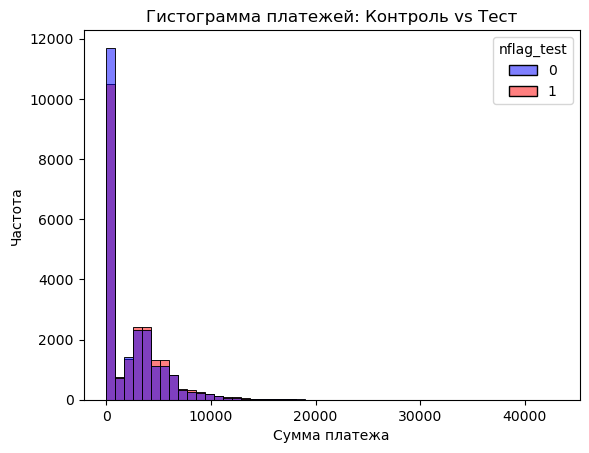

In [10]:

sns.histplot(data=cleaned_data, x='amt_payment', hue='nflag_test', bins=50, palette=['blue', 'red'], alpha=0.5)


plt.title('Гистограмма платежей: Контроль vs Тест')


plt.xlabel('Сумма платежа')
plt.ylabel('Частота')


plt.show()


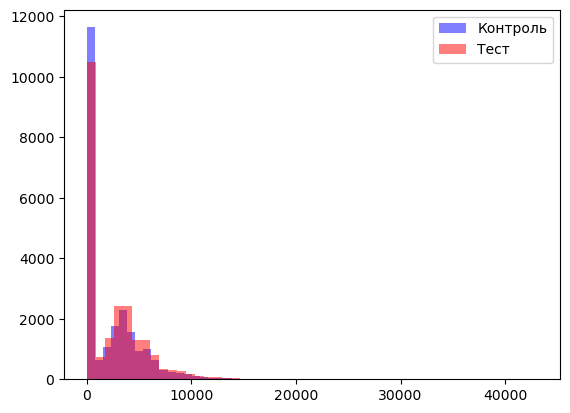

In [11]:
control_group_pay = cleaned_data[cleaned_data['nflag_test'] == 0]['amt_payment']
test_group_pay = cleaned_data[cleaned_data['nflag_test'] == 1]['amt_payment']

plt.hist(control_group_pay, bins=50, alpha=0.5, label='Контроль', color='blue')
plt.hist(test_group_pay, bins=50, alpha=0.5, label='Тест', color='red')

plt.legend()

plt.show()


In [12]:
test_calc(control_group_pay, test_group_pay)

Есть статистически значимая разница между средними (p_value = 3.3214645838934018e-21).


(-9.456798235171377, 3.3214645838934018e-21)

In [13]:
cleaned_data['converted'] = (cleaned_data['amt_payment'] > 0).astype(int)

control_group_conv = cleaned_data[cleaned_data['nflag_test'] == 0]['converted']
test_group_conv = cleaned_data[cleaned_data['nflag_test'] == 1]['converted']  

In [14]:
test_calc(control_group_conv, test_group_conv)

Есть статистически значимая разница между средними (p_value = 1.7338073027564523e-20).


(-9.282032730948323, 1.7338073027564523e-20)

In [15]:
mann_whitney_func (control_group_pay, test_group_pay)

Существует статистически значимая разница между распределениями (p_value = 3.008345273971901e-24).


(243344369.0, 3.008345273971901e-24)

In [16]:
mann_whitney_func (control_group_conv, test_group_conv)

Существует статистически значимая разница между распределениями (p_value = 1.8043406994299902e-20).


(245519959.0, 1.8043406994299902e-20)

In [17]:
control_group_pay_msc = cleaned_data.loc[ (cleaned_data['nflag_test'] == 0) & (cleaned_data['city'] == 'Москва'),
    'amt_payment']

test_group_pay_msc = cleaned_data.loc[ (cleaned_data['nflag_test'] == 1) & (cleaned_data['city'] == 'Москва'),
    'amt_payment']

In [18]:
test_calc(control_group_pay_msc, test_group_pay_msc)

Есть статистически значимая разница между средними (p_value = 1.757549439555765e-14).


(-7.676511027843395, 1.757549439555765e-14)

In [19]:
control_group_conv_msk = cleaned_data.loc[ (cleaned_data['nflag_test'] == 0) & (cleaned_data['city'] == 'Москва'), 'converted'] 
test_group_conv_msk = cleaned_data.loc [ (cleaned_data['nflag_test'] == 1) & (cleaned_data['city'] == 'Москва'),'converted']  


In [20]:
test_calc(control_group_conv_msk, test_group_conv_msk)

Есть статистически значимая разница между средними (p_value = 6.194689260032549e-10).


(-6.190312288026297, 6.194689260032549e-10)

In [21]:
mann_whitney_func (control_group_pay_msc, test_group_pay_msc)

Существует статистически значимая разница между распределениями (p_value = 7.010591402203484e-16).


(17582441.5, 7.010591402203484e-16)

In [22]:
mann_whitney_func (control_group_conv_msk, test_group_conv_msk)

Существует статистически значимая разница между распределениями (p_value = 6.370381156613038e-10).


(18028079.0, 6.370381156613038e-10)

In [23]:
control_group_pay_spb = cleaned_data.loc[ (cleaned_data['nflag_test'] == 0) & (cleaned_data['city'] == 'Санкт-Петербург'),
    'amt_payment']

test_group_pay_spb = cleaned_data.loc[ (cleaned_data['nflag_test'] == 1) & (cleaned_data['city'] == 'Санкт-Петербург'),
    'amt_payment']

In [24]:
test_calc(control_group_pay_spb, test_group_pay_spb)

Есть статистически значимая разница между средними (p_value = 2.3198088937974163e-18).


(-8.759635784179547, 2.3198088937974163e-18)

In [25]:
control_group_conv_spb = cleaned_data.loc[ (cleaned_data['nflag_test'] == 0) & (cleaned_data['city'] == 'Санкт-Петербург'),  
        'converted'] 
test_group_conv_spb = cleaned_data.loc [ (cleaned_data['nflag_test'] == 1) & (cleaned_data['city'] == 'Санкт-Петербург'),  
        'converted']  

In [26]:
test_calc(control_group_conv_spb, test_group_conv_spb)

Есть статистически значимая разница между средними (p_value = 1.065825659919673e-20).


(-9.352468686561785, 1.065825659919673e-20)

In [27]:
mann_whitney_func (control_group_pay_spb, test_group_pay_spb)

Существует статистически значимая разница между распределениями (p_value = 2.0392184217953754e-20).


(8809444.5, 2.0392184217953754e-20)

In [28]:
mann_whitney_func (control_group_conv_spb, test_group_conv_spb)

Существует статистически значимая разница между распределениями (p_value = 1.3118606823466691e-20).


(8881151.0, 1.3118606823466691e-20)

In [29]:
control_group_pay_others = cleaned_data.loc[ (cleaned_data['nflag_test'] == 0) & (~cleaned_data['city'].isin(['Москва', 'Санкт-Петербург'])),
    'amt_payment']
test_group_pay_others = cleaned_data.loc[ (cleaned_data['nflag_test'] == 1) & (~cleaned_data['city'].isin(['Москва', 'Санкт-Петербург'])),
    'amt_payment']



In [30]:
test_calc(control_group_pay_others, test_group_pay_others)

Есть статистически значимая разница между средними (p_value = 0.005116960359573606).


(-2.799833948375294, 0.005116960359573606)

In [31]:
control_group_conv_others = cleaned_data.loc[ (cleaned_data['nflag_test'] == 0) & (~cleaned_data['city'].isin(['Москва', 'Санкт-Петербург'])),
    'converted']
test_group_conv_others = cleaned_data.loc[ (cleaned_data['nflag_test'] == 1) & (~cleaned_data['city'].isin(['Москва', 'Санкт-Петербург'])),
    'converted']

In [32]:
test_calc(control_group_conv_others, test_group_conv_others)

Есть статистически значимая разница между средними (p_value = 0.007211139569659334).


(-2.6871624139823846, 0.007211139569659334)

In [33]:
mann_whitney_func (control_group_pay_others, test_group_pay_others)

Существует статистически значимая разница между распределениями (p_value = 0.0049446987638856145).


(71035036.5, 0.0049446987638856145)

In [34]:
mann_whitney_func (control_group_conv_others, test_group_conv_others)

Существует статистически значимая разница между распределениями (p_value = 0.0072137043853313).


(71219383.0, 0.0072137043853313)

In [35]:
from scipy.stats import ttest_ind, mannwhitneyu


final_table = pd.DataFrame()

for i in cleaned_data['city'].unique():
    df_loc = cleaned_data[cleaned_data['city']==i]
    
    for j in df_loc['id_trading_point'].unique():
        
        df_loc_f      = df_loc[df_loc['id_trading_point']==j]
        
        count_test    = len(df_loc_f[df_loc_f['nflag_test']==1])
        count_control = len(df_loc_f[df_loc_f['nflag_test']==0])
        count_all     = count_test + count_control
        sigma_test    = df_loc_f[df_loc_f['nflag_test']==1]['amt_payment'].std()
        sigma_control = df_loc_f[df_loc_f['nflag_test']==0]['amt_payment'].std()
        
        avg_test    = np.mean(df_loc_f[df_loc_f['nflag_test']==1]['amt_payment'])
        avg_control = np.mean(df_loc_f[df_loc_f['nflag_test']==0]['amt_payment'])
        diff        = avg_test - avg_control
        
        s_a,p_a  = test_calc(df_loc_f[df_loc_f['nflag_test']==1]['amt_payment'], df_loc_f[df_loc_f['nflag_test']==0]['amt_payment'])
        s_p,p_p  = test_calc(df_loc_f[df_loc_f['nflag_test']==1]['nflag_paid'], df_loc_f[df_loc_f['nflag_test']==0]['nflag_paid'])
        m_s, m_p = mann_whitney_func(df_loc_f[df_loc_f['nflag_test']==1]['amt_payment'], df_loc_f[df_loc_f['nflag_test']==0]['amt_payment'])

        final_table = final_table.append({  'city':i, 'id_trading_point':j
                                        , 'count_test':count_test, 'count_control':count_control, 'count_all':count_all
                                        , 'avg_test':avg_test, 'avg_control':avg_control
                                        , 'sigma_test':sigma_test, 'sigma_control':sigma_control
                                        , 'diff':diff  , 'abs_ttest_s':s_a, 'abs_ttest_p':p_a, 'pr_ttest_s':s_p \
                                       
                                     }, ignore_index=True)

final_table['лейбл'] = np.where((final_table['abs_ttest_p'] < .05) & (final_table['diff'] > 0), 'положительный'
                                , np.where((final_table['abs_ttest_p'] < .05) & (final_table['diff'] < 0), 'отрицательный', 'нейтральный'))
final_table['percent_count'] = (final_table['count_all'] / final_table['count_all'].sum())

final_table

Есть статистически значимая разница между средними (p_value = 6.983206901274464e-07).
Есть статистически значимая разница между средними (p_value = 3.381305634110329e-08).
Существует статистически значимая разница между распределениями (p_value = 1.8091938713109172e-07).
Нет статистически значимой разницы между средними (p_value = 0.07683710303752554).
Есть статистически значимая разница между средними (p_value = 0.0281319517757112).
Существует статистически значимая разница между распределениями (p_value = 0.045325599351465).
Есть статистически значимая разница между средними (p_value = 0.0007003816631342835).
Есть статистически значимая разница между средними (p_value = 0.0002501350617999005).
Существует статистически значимая разница между распределениями (p_value = 0.00037312135586840974).
Нет статистически значимой разницы между средними (p_value = 0.21988338416718506).
Нет статистически значимой разницы между средними (p_value = 0.16995475575275115).
Нет статистически значимой ра

C:\Users\User\AppData\Local\Temp\ipykernel_10816\1421089764.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_table = final_table.append({  'city':i, 'id_trading_point':j
C:\Users\User\AppData\Local\Temp\ipykernel_10816\1421089764.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_table = final_table.append({  'city':i, 'id_trading_point':j
C:\Users\User\AppData\Local\Temp\ipykernel_10816\1421089764.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_table = final_table.append({  'city':i, 'id_trading_point':j
C:\Users\User\AppData\Local\Temp\ipykernel_10816\1421089764.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat in

Есть статистически значимая разница между средними (p_value = 1.1223868363766535e-09).
Есть статистически значимая разница между средними (p_value = 2.2229287062995777e-05).
Существует статистически значимая разница между распределениями (p_value = 2.075765659611164e-09).
Есть статистически значимая разница между средними (p_value = 0.034929468998951815).
Есть статистически значимая разница между средними (p_value = 0.006353519667404301).
Существует статистически значимая разница между распределениями (p_value = 0.026157259000973803).
Нет статистически значимой разницы между средними (p_value = 0.968450028951438).
Нет статистически значимой разницы между средними (p_value = 0.5675529827327949).
Нет статистически значимой разницы между распределениями (p_value = 0.7931235664627905).
Нет статистически значимой разницы между средними (p_value = 0.8079974055696059).
Нет статистически значимой разницы между средними (p_value = 0.6657638438121836).
Нет статистически значимой разницы между ра

C:\Users\User\AppData\Local\Temp\ipykernel_10816\1421089764.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_table = final_table.append({  'city':i, 'id_trading_point':j
C:\Users\User\AppData\Local\Temp\ipykernel_10816\1421089764.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_table = final_table.append({  'city':i, 'id_trading_point':j
C:\Users\User\AppData\Local\Temp\ipykernel_10816\1421089764.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_table = final_table.append({  'city':i, 'id_trading_point':j
C:\Users\User\AppData\Local\Temp\ipykernel_10816\1421089764.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat in

Нет статистически значимой разницы между средними (p_value = 0.5524803558814528).
Нет статистически значимой разницы между средними (p_value = 0.13018833739167393).
Нет статистически значимой разницы между распределениями (p_value = 0.30962160412467155).
Есть статистически значимая разница между средними (p_value = 0.024501004890271766).
Нет статистически значимой разницы между средними (p_value = 0.20807190183768315).
Нет статистически значимой разницы между распределениями (p_value = 0.06467166885640406).
Нет статистически значимой разницы между средними (p_value = 0.1297970685161915).
Нет статистически значимой разницы между средними (p_value = 0.5330927574323401).
Нет статистически значимой разницы между распределениями (p_value = 0.40184000481310433).
Есть статистически значимая разница между средними (p_value = 7.222518974571453e-20).
Есть статистически значимая разница между средними (p_value = 7.087699806064145e-21).
Существует статистически значимая разница между распределения

C:\Users\User\AppData\Local\Temp\ipykernel_10816\1421089764.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_table = final_table.append({  'city':i, 'id_trading_point':j
C:\Users\User\AppData\Local\Temp\ipykernel_10816\1421089764.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_table = final_table.append({  'city':i, 'id_trading_point':j
C:\Users\User\AppData\Local\Temp\ipykernel_10816\1421089764.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_table = final_table.append({  'city':i, 'id_trading_point':j
C:\Users\User\AppData\Local\Temp\ipykernel_10816\1421089764.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat in

,city,id_trading_point,count_test,count_control,count_all,avg_test,avg_control,sigma_test,sigma_control,diff,abs_ttest_s,abs_ttest_p,pr_ttest_s,лейбл,percent_count
0,Санкт-Петербург,453.0,1066,1049,2115,2501.966229,1889.923737,2993.442540,2648.659303,612.042492,4.976910,6.983207e-07,5.541076,положительный,0.046670
1,Санкт-Петербург,112.0,652,683,1335,2488.115031,2218.636896,2778.179183,2780.790660,269.478135,1.770712,7.683710e-02,2.197840,нейтральный,0.029458
2,Санкт-Петербург,117.0,625,587,1212,2582.297600,2050.691652,2835.004503,2595.737792,531.605948,3.398196,7.003817e-04,3.673055,положительный,0.026744
3,Санкт-Петербург,309.0,240,238,478,2706.279167,2392.894958,2814.939849,2761.938716,313.384209,1.228455,2.198834e-01,1.374431,нейтральный,0.010548
4,Санкт-Петербург,576.0,630,657,1287,1594.436508,1342.129376,2683.727211,2415.822664,252.307132,1.774073,7.628783e-02,1.535345,нейтральный,0.028399
5,Санкт-Петербург,900.0,335,341,676,2450.991045,1689.791789,2865.607356,2492.472611,761.199256,3.686914,2.452534e-04,3.718411,положительный,0.014917
6,Санкт-Петербург,213.0,232,255,487,2977.629310,2277.611765,2905.494362,2710.043413,700.017546,2.750752,6.168215e-03,2.524813,положительный,0.010746
7,Санкт-Петербург,801.0,225,212,437,2925.142222,2352.283019,2774.292063,2928.285838,572.859203,2.099991,3.630501e-02,2.475441,положительный,0.009643
8,Санкт-Петербург,573.0,177,160,337,2929.045198,1641.212500,3201.098137,2619.044781,1287.832698,4.016569,7.294074e-05,4.888660,положительный,0.007436
9,Санкт-Петербург,891.0,159,167,326,2618.949686,1980.658683,2899.782464,2489.571942,638.291003,2.135593,3.346204e-02,2.176540,положительный,0.007194


In [41]:

writer = pd.ExcelWriter("результаты.xlsx", engine="xlsxwriter")


positive_label = final_table[final_table['лейбл'] == 'положительный']
negative_label = final_table[final_table['лейбл'] == 'отрицательный']
neutral_label = final_table[final_table['лейбл'] == 'нейтральный']


positive_label.to_excel(writer, sheet_name="Положительные", index=False)
negative_label.to_excel(writer, sheet_name="Отрицательные", index=False)
neutral_label.to_excel(writer, sheet_name="Нейтральные", index=False)


writer.close()



In [36]:

conversion_control = final_table['avg_control'].values[0]/100 


conversion_test = final_table['avg_test'].values[1]/100


nobs = min(final_table['count_all'])

In [37]:
def chi2_effect_size(p0, p1):
    return np.sqrt(((p0 - p1)**2 / p0))

In [ ]:
import statsmodels.stats.power as smp 

chipower = smp.GofChisquarePower() 


power = 0.8 
alpha = 0.05
nobs = chipower.solve_power(effect_size = chi2_effect_size(avg_control, avg_test), 
                                               nobs = None, 
                                               alpha = alpha, 
                                               power = power)

print (chipower)